# Train a CNN on LSE cycles for gender prediction

In [1]:
# Imports
import os
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
np.random.seed(42)

import threading
import pickle
import random

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, Input, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard

from sklearn.utils import class_weight

Using TensorFlow backend.
/home/groups/euan/users/danjwu/miniconda3/envs/MHC/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/groups/euan/users/danjwu/miniconda3/envs/MHC/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/groups/euan/users/danjwu/miniconda3/envs/MHC/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype

In [48]:
# =============================================================================
# PARAMETERS
# =============================================================================

#File locations
output_dir = "/scratch/PI/euan/projects/mhc/code/daniel_code/results"
label_table_file = "/scratch/PI/euan/projects/mhc/code/daniel_code/tables/all.tsv"
train_data_path = r"/scratch/PI/euan/projects/mhc/code/daniel_code/data/gender_cycles.hdf5"



model_metrics = ['accuracy'] #,tpr,tnr,fpr,fnr,precision,f1]

#Training parameters
batch_size = 512
canMultiprocess = False

#Training metrics
#from concise.metrics import tpr, tnr, fpr, fnr, precision, f1

from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []
 
    def on_epoch_end(self, epoch, logs={}):
        val_predict = (np.asarray(self.model.predict(self.validation_data[0], batch_size = batch_size))).round()
        val_targ = self.validation_data[1]
        
        _val_f1 = f1_score(val_targ, val_predict)
        _val_recall = recall_score(val_targ, val_predict)
        _val_precision = precision_score(val_targ, val_predict)
        
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        print(f' — val_f1: {_val_f1} — val_precision: {_val_precision} — val_recall {_val_recall}')
        return
 
metrix = Metrics()


# Data visualization and processing

In [3]:
#Look at what the data file looks like
with tables.open_file(train_data_path, mode='r') as file:
    print(file)
    
    #Test various data access schemes
    import timeit
    
    idxs = np.random.randint(0, 32006, size=(320,))
        
    #timeit.timeit(stmt='print(file.root.data[:50])', number=10)
    #%timeit e = [file.root.data[i] for i in range(320)]
    #print(idxs)
    #%timeit e = [file.root.data[i] for i in idxs]


/scratch/PI/euan/projects/mhc/code/daniel_code/data/gender_cycles.hdf5 (File) 'cycles'
Last modif.: 'Thu Jul 11 12:00:46 2019'
Object Tree: 
/ (RootGroup) 'cycles'
/data (EArray(303520, 100, 4)) ''
/labels (EArray(303520,)) ''



(100, 300)


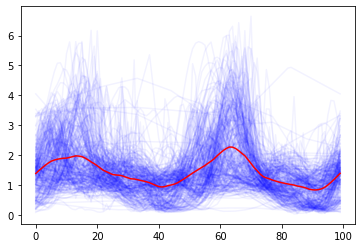

In [4]:
#Visualize some data points
with tables.open_file(train_data_path, mode='r') as file:
    subset = file.root.data[0:300, :, -1].T
    print(subset.shape)
    plt.plot(subset, color='b', alpha=0.05)
    plt.plot(np.mean(subset, axis=1), color ='r')

In [5]:
#Look at our label file
label_df = pd.read_csv(label_table_file, 
                       header=None,
                       names=["Healthcode", "Age", "Gender", "Ethnicity", "Version"], 
                       delimiter='\t')
label_df = label_df.set_index('Healthcode')
label_df
#Access a label like this
print(label_df.loc[label_df.index[0], 'Gender'])

Healthcode
d04c954e-979b-4b24-999a-aa4c4a9f90e9    Male
d04c954e-979b-4b24-999a-aa4c4a9f90e9    Male
Name: Gender, dtype: object


(128, 1, 4, 100)


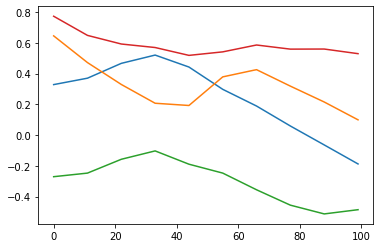

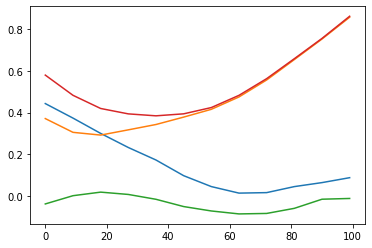

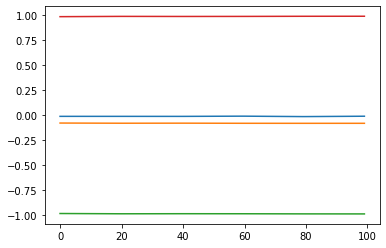

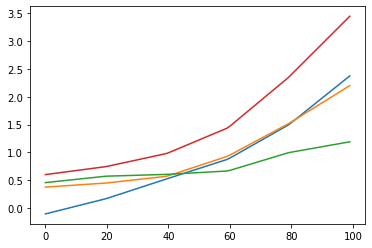

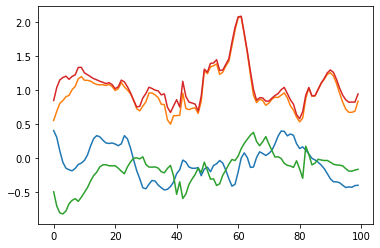

In [6]:
# =============================================================================
# Data generator
# =============================================================================
def extract_labels(label_table_path):
    '''
    Returns a dataframe indexed by healthCodes with columns of requested labels
    taken from the label table file
    '''
    label_df = pd.read_csv(label_table_path, 
                           header=None,
                           names=["Healthcode", "Age", "Gender", "Ethnicity", "Version"], 
                           delimiter='\t')
    #Encode to bytes
    label_df['Healthcode'] = label_df['Healthcode'].map(lambda x: x.encode('UTF-8'))
    #Drop duplicates
    label_df = label_df.set_index('Healthcode')
    label_df = label_df.loc[~label_df.index.duplicated(keep='first')]
    
    #Drop invalid gender values
    label_df = label_df[(label_df.Gender =='Male') | (label_df.Gender == 'Female')]
    
    return label_df

def parse_label(code, label_df):
    """
    Helper function that parses the labels on survey data for a given code
    """
    
    return label_df.loc[code, 'Gender'] == "Male"
        
class SixMWTSequence(keras.utils.Sequence):
    '''
    SixMWTSequence
    Extends keras inbuilt sequence to create a data generator
    Saves on RAM by loading data from hdf5 files in memory
    Shuffle increases read time by 20x but makes the batches mixed
    '''
    def __init__(self, data_file, batch_size, label_df, shuffle=True, val=False, val_split = 0.7):
        #Open up file
        #self.lock = threading.Lock()
        self.data = data_file.root.data
        self.labels = data_file.root.labels
        
        #Track labels and batch size
        self.label_map = label_df
        self.batch_size = batch_size
        self.inval_hc = set()
        self.val = val
        self.val_split = val_split
        
        #Partition the dataset into batches
        if val:
            num_data = int(self.labels.shape[0] * (1-val_split))
            self.order = np.arange(self.labels.shape[0] - num_data, self.labels.shape[0])
        else:
            num_data = int(self.labels.shape[0] * val_split)
            self.order = np.arange(num_data)
            
        self.length = num_data // self.batch_size
                
        #Shuffle
        if(shuffle):
            np.random.shuffle(self.order)        

    def __len__(self):

        return self.length

    def __getitem__(self, idx):
        
        start_idx = idx*self.batch_size
        stop_idx = (idx + 1)*self.batch_size
                    
        idxs = self.order[start_idx:stop_idx]
        
        #Get the batch members
        batch_x = np.array([self.data[idx] for idx in idxs])
        y_healthcodes = np.array([self.labels[idx] for idx in idxs])
                
        #Convert healthcodes to genders
        batch_y = np.empty(len(y_healthcodes), dtype = bool)
        for i in range(len(batch_y)):
            try:
                batch_y[i] = parse_label(y_healthcodes[i], self.label_map)
                
            except KeyError:
                #Currently just assign random gender. This is a dumb idea.
                #print(f"Invalid Healthcode: {y_healthcodes[i]}")
                self.inval_hc.add(y_healthcodes[i])
                batch_y[i] = bool(random.randint(0,1))

        #Normalize over time dimension
        #print(np.mean(batch_x, axis = -2))

        #batch_x -= np.expand_dims(np.mean(batch_x, axis = 1), axis=1)
        #batch_x = keras.utils.normalize(batch_x, axis=2)
        #print(np.mean(batch_x, axis = -2))
            
        #Add a extra dimension
        batch_x = np.expand_dims(batch_x, axis=1)
        #Swap axes
        batch_x = np.swapaxes(batch_x, -1, -2)
            
        return batch_x, batch_y

label_df = extract_labels(label_table_file)
#Look at what the data file looks like
with tables.open_file(train_data_path, mode='r') as file:
    train_gen = SixMWTSequence(file, batch_size, label_df, val=False)
    val_gen = SixMWTSequence(file, batch_size, label_df, val=True)    
    print(train_gen[20][0].shape)
    window = train_gen[20][0]
    
    for i in range(5):
        plt.figure()
        plt.plot(window[i, :, :].squeeze().T)
        plt.show()

In [10]:
#Make a baby validation dataset in memory for tensorboard callback
X_val = np.empty((0, 1, 4, 100))
y_val = np.empty((0,))

with tables.open_file(train_data_path, mode='r') as file:
    val_gen = SixMWTSequence(file, batch_size, label_df, val=True)  
    for batch_x, batch_y in val_gen:
        X_val = np.concatenate((X_val, batch_x), axis=0)
        y_val = np.concatenate((y_val, batch_y), axis=0)

In [11]:
#Make a baby train dataset in memory
X_train = np.empty((0, 1, 4, 100))
y_train = np.empty((0,))

with tables.open_file(train_data_path, mode='r') as file:
    train_gen = SixMWTSequence(file, batch_size, label_df, val=False)  
    for batch_x, batch_y in train_gen:
        X_train = np.concatenate((X_train, batch_x), axis=0)
        y_train = np.concatenate((y_train, batch_y), axis=0)

In [16]:
np.save('gender_X_train.npy', X_train)
np.save('gender_X_val.npy', X_val)
np.save('gender_y_train.npy', y_train)
np.save('gender_y_val.npy', y_val)

In [7]:
# =============================================================================
# OLD: Generator-based training
# =============================================================================

with tables.open_file(train_data_path, mode='r') as file:
    train_gen = SixMWTSequence(file, batch_size, label_df, val=False)
    val_gen = SixMWTSequence(file, batch_size, label_df, val=True)    
    
    num_train = len(train_gen)
    num_val = len(val_gen)
    print("There are {} training batches and {} validation batches".format(num_train, num_val))
    
    num_epochs = 1000
    
    #Calculate class weights from 100 batches
    temp = np.array([])
    num_smpls = min(100, num_train)
    rand_idxs = random.sample(list(range(num_train)), num_smpls)
    for batch_num in rand_idxs:
        _, temp_y = train_gen[batch_num]
        temp = np.concatenate((temp, temp_y))
    class_weights = dict(enumerate(class_weight.compute_class_weight('balanced',
                                                     np.unique(temp),
                                                     temp)))
    
    print("Our class weights are {}".format(class_weights))
    #Training

#    history = model.fit_generator(generator=train_gen,
#                              epochs=num_epochs,
#                              callbacks = cb_list,
#                              validation_data=val_gen,
#                              class_weight=class_weights,
#                              shuffle=True)



There are 1659 training batches and 711 validation batches
Our class weights are {0: 1.6218955904713634, 1: 0.7228371357578496}


# Training

In [ ]:
#Load 3 axis data (OLD)
X_train = np.load('gender_X_train.npy')
y_train = np.load('gender_y_train.npy')

X_val = np.load('gender_X_val.npy')
y_val = np.load('gender_y_val.npy')

In [3]:
#Load 15 axis data
print('Beginning loading')
X_train = np.load('processed_datasets/gender_X_15.npy')
y_train = np.load('processed_datasets/gender_y_15.npy')
ids_train = np.load('processed_datasets/gender_ids_15.npy')

#X_train = np.load('processed_datasets/Sex_X_15_filtered.npy')
#y_train = np.load('processed_datasets/Sex_y_15_filtered.npy')
#ids_train = np.load('processed_datasets/Sex_ids_15_filtered.npy')

print('Finished loading, beginning X_train axis adjustment')

#Change X_train to weird format
X_train = np.expand_dims(X_train, 1)
X_train = np.swapaxes(X_train, -1, -2)

print('Beginning y_train encoding')

#Convert string to binary labels
y_train = y_train == 'Male'

#from sklearn.model_selection import train_test_split
#X_train, X_val, y_train, y_val, ids_train, ids_val = train_test_split(X_train, y_train, ids_train, train_size = 0.8)

#Randomize
if False:
    print('Data will be randomized.')
    idxs = np.arange(X_train.shape[0])
    np.random.shuffle(idxs)
    X_train = X_train[idxs]
    y_train = y_train[idxs]
    ids_train = ids_train[idxs]
else:
    print('Data is NOT randomized.')

print('Beginning data splitting')

split_num = int(0.1*X_train.shape[0])
X_test = X_train[-split_num:]
y_test = y_train[-split_num:]
ids_test = ids_train[-split_num:]

X_val = X_train[-3*split_num:-split_num]
y_val = y_train[-3*split_num:-split_num]
ids_val = ids_train[-3*split_num:-split_num]

X_train = X_train[:-3*split_num]
y_train = y_train[:-3*split_num]
ids_train = ids_train[:-3*split_num]

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

Beginning loading
Finished loading, beginning X_train axis adjustment
Beginning y_train encoding
Data is NOT randomized.
Beginning data splitting


((2443483, 1, 15, 100),
 (698136, 1, 15, 100),
 (349068, 1, 15, 100),
 (2443483,),
 (698136,),
 (349068,))

In [4]:
#Forcibly balance the dataset
female_idxs = np.nonzero(y_train == 0)[0]
male_idxs = np.nonzero(y_train)[0]
num_females = len(female_idxs)
bal_idxs = np.concatenate((female_idxs, male_idxs[:num_females]), axis = 0)
X_train = X_train[bal_idxs]
y_train = y_train[bal_idxs]
ids_train = ids_train[bal_idxs]
X_train.shape, X_val.shape, y_train.shape, y_val.shape, ids_train.shape, ids_val.shape

((1185960, 1, 15, 100),
 (698136, 1, 15, 100),
 (1185960,),
 (698136,),
 (1185960,),
 (698136,))

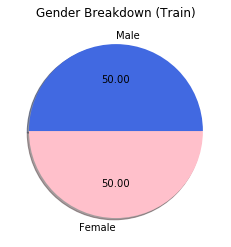

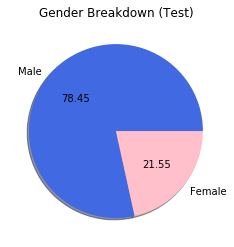

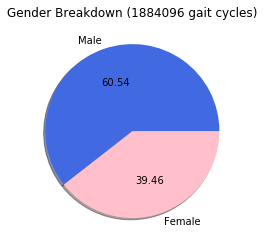

In [5]:
#Profile the dataset
num_male = np.sum(y_train == 1)
num_female = np.sum(y_train == 0)
plt.figure()
plt.pie([num_male, num_female], 
        labels = ['Male', 'Female'], 
        colors=['royalblue', 'pink'], 
        autopct = '%.2f', 
        shadow = True)
plt.title("Gender Breakdown (Train)")
plt.show()

#Profile the dataset
num_male = np.sum(y_val == 1)
num_female = np.sum(y_val == 0)
plt.figure()
plt.pie([num_male, num_female], 
        labels = ['Male', 'Female'], 
        colors=['royalblue', 'pink'], 
        autopct = '%.2f', 
        shadow = True)
plt.title("Gender Breakdown (Test)")
plt.show()

#Profile the dataset
num_male = np.sum(np.concatenate((y_train, y_val)) == 1)
num_female = np.sum(np.concatenate((y_train, y_val)) == 0)
plt.figure()
plt.pie([num_male, num_female], 
        labels = ['Male', 'Female'], 
        colors=['royalblue', 'pink'], 
        autopct = '%.2f', 
        shadow = True)
plt.title(f"Gender Breakdown ({num_male + num_female} gait cycles)")
plt.show()

In [51]:
#Define a model
def get_model():
    from keras.layers import LSTM, Permute
    
    model = Sequential()
    # ENTRY LAYER
    model.add(Reshape((15, 100), input_shape=(1, 15, 100)))
    model.add(Permute((2, 1), input_shape=(15, 100)))
    model.add(LSTM(32, dropout=0.0, recurrent_dropout=0.0, return_sequences=True))
    model.add(LSTM(32, dropout=0.0, recurrent_dropout=0.0, return_sequences=True))
    model.add(LSTM(32, dropout=0.0, recurrent_dropout=0.0, return_sequences=False))

    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [6]:
import functools
import json

import keras.backend as K

from keras.layers import Permute, Dense, Input, Conv2D, concatenate, MaxPooling2D
from keras.layers import ELU, BatchNormalization, Dropout, GlobalAveragePooling2D
from keras.models import Model

# %load model_util
from keras.layers import Input
from keras.regularizers import l2


REG_P = dict(kernel_regularizer=l2(0.01))


def _create_input(input_shape, input_tensor=None, name='input'):
    """
    Select a correct input tensor based on shape and instance specification.

    # Arguments
        input_shape: Input shape tuple
        input_tensor: Existing tensor to wrap into the `Input` layer.
                      If set, the layer will not create a placeholder tensor.
        name: Name string for layer.

    # Returns
        Input Tensor
    """
    if input_tensor is None:
        return Input(shape=input_shape, name=name)

    if not K.is_keras_tensor(input_tensor):
        return Input(tensor=input_tensor, shape=input_shape, name=name)

    return input_tensor


def _conv_block(units, block=1, layer=1, sensor='acc'):
    """
    Create VGG style convolutional block.

    Deviations from original paper.
        - Remove `Dropout`
        - Added `BatchNormalization`
        - He-normal initialization
        - Uses `ELU` Activation
        
    # Arguments
        units: conv filters
        block: block number within network (used for naming)
        layer: layer number within block (used for naming)
        sensor: sensor name (used for naming)
        
    # Returns
        callable
    """
    def layer_wrapper(inp):
        x = Conv2D(units, (1, 3), padding='same', kernel_initializer='he_normal',
                   name=f'block{block}_conv{layer}_{sensor}', **REG_P)(inp)
        x = BatchNormalization(epsilon=0.23, name=f'block{block}_bn{layer}_{sensor}')(x)
        x = ELU(name=f'block{block}_act{layer}_{sensor}')(x)
        return x

    return layer_wrapper


def _dense_block(units, dropout=0.3, name='fc1'):
    """
    Create VGG fully connected block.

    # Deviations from original paper.
        - Added `BatchNormalization`
        - Uses `ELU` Activation
    
    # Arguments
        units: fc layer dimensionality
        dropout: dropout probability
        name: prefix for dense layers

    # Returns
        callable
    """

    def layer_wrapper(inp):
        x = Dense(units, name=f'{name}', **REG_P)(inp)
        x = BatchNormalization(epsilon=0.23, name=f'{name}_bn')(x)
        x = ELU(name=f'{name}_act')(x)
        x = Dropout(dropout, name=f'{name}_dropout')(x)
        return x

    return layer_wrapper


def _vgg_body(factor=2, sensor='acc'):
    """
    VGG Network Body containing convolutional blocks
    
    # Arguments
        factor: scaling factor to reduce network filter width
        sensor: sensor name
        
    # Return
        callable
    """

    _vgg_conv_block = functools.partial(_conv_block, sensor=sensor)

    def layer_wrapper(inp):
        x = Permute((1, 3, 2), name=f'swapaxes_{sensor}')(inp)

        # Block 1
        x = _vgg_conv_block(64 // factor, block=1, layer=1)(x)
        x = _vgg_conv_block(64 // factor, block=1, layer=2)(x)
        x = MaxPooling2D((1, 2), name=f'block1_pool_{sensor}')(x)

        # Block 2
        x = _vgg_conv_block(128 // factor, block=2, layer=1)(x)
        x = _vgg_conv_block(128 // factor, block=2, layer=2)(x)
        x = MaxPooling2D((1, 2), name=f'block2_pool_{sensor}')(x)

        # Block 3
        x = _vgg_conv_block(256 // factor, block=3, layer=1)(x)
        x = _vgg_conv_block(256 // factor, block=3, layer=2)(x)
        x = _vgg_conv_block(256 // factor, block=3, layer=3)(x)
        x = MaxPooling2D((1, 2), name=f'block3_pool_{sensor}')(x)

        # Block 4
        x = _vgg_conv_block(512 // factor, block=4, layer=1)(x)
        x = _vgg_conv_block(512 // factor, block=4, layer=2)(x)
        x = _vgg_conv_block(512 // factor, block=4, layer=3)(x)
        x = MaxPooling2D((1, 2), name=f'block4_pool_{sensor}')(x)

        # Block 5
        x = _vgg_conv_block(512 // factor, block=5, layer=1)(x)
        x = _vgg_conv_block(512 // factor, block=5, layer=2)(x)
        x = _vgg_conv_block(512 // factor, block=5, layer=3)(x)
        x = MaxPooling2D((1, 2), name=f'block5_pool_{sensor}')(x)

        return x

    return layer_wrapper

def VGG16Net(input_shape=None, input_tensor=(None, None),
             classes=1000, dropout=0.3, factor=2):
    """
    Modified VGG architecture
        https://arxiv.org/abs/1409.1556

    # Arguments
        input_shape: shape tuple
        input_tensor: Keras tensor (i.e. output of `layers.Input()`) to use as image input for the model.
        classes: optional number of classes to classify images
        dropout: dropout applied to fc layers
        factor: scaling factor to reduce network filter width

    # Returns
        A Keras model instance.
    """
    assert input_shape or all(input_tensor), f'Must provide at least one: input_shape, input_tensor'

    # Two Inputs
    img_input_acc = _create_input(input_shape, input_tensor=input_tensor[0], name='acc_input')

    # Accelerometer and Gyroscope Conv Blocks
    x = _vgg_body(factor=factor, sensor='acc')(img_input_acc)

    # Merge and Pool Channels
    x = GlobalAveragePooling2D(name='avgpool')(x)

    # FC Layers
    x = _dense_block(4098 // factor, dropout=dropout, name='fc1')(x)
    x = _dense_block(4098 // factor, dropout=dropout, name='fc2')(x)

    # Classification block
    if classes == 2:
        x = Dense(1, activation = 'sigmoid', name='predictions')(x)
    else:
        x = Dense(classes, activation='softmax', name='predictions')(x)

    return Model(img_input_acc, x, name='VGG16Net')

from keras.callbacks import ModelCheckpoint

class MultiGPUCheckpoint(ModelCheckpoint):
    """
    Drop in replacement for `ModelCheckpoint` callback which fixes a bug
    when saving models wrapped in `keras.utils.multi_gpu_model`.

    Please see:
        https://github.com/keras-team/keras/issues/8123#issuecomment-409395274

    Works with both single and multi-gpu configurations.
    """
    def set_model(self, model):
        layer = model.layers[-2]
        if isinstance(layer, Model) and layer.input_names == model.input_names:
            self.model = layer
        else:
            self.model = model
                

In [52]:
#Set the model up
#model = get_mod_model()
model = get_model()
#model = VGG16Net(input_shape=(1, 15, 100), classes=2)

print(model.summary())

#Define optimizer
adam = keras.optimizers.Adam() #Default lr is 0.001

model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=model_metrics)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 15, 100)           0         
_________________________________________________________________
permute_2 (Permute)          (None, 100, 15)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100, 32)           6144      
_________________________________________________________________
lstm_5 (LSTM)                (None, 100, 32)           8320      
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 22,817
Trainable params: 22,817
Non-trainable params: 0
_________________________________________________________________
None


In [49]:
#Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=4, min_lr=1e-7, verbose=1)

early_stop = EarlyStopping(patience=8, verbose=1, restore_best_weights=True)

#tb = TensorBoard(log_dir=os.path.join(output_dir, 'logs'), 
#                 write_graph=False,) 
                 #histogram_freq=5, 
                 #embeddings_freq=5, 
                 #embeddings_layer_names=['fc1'],
                 #mbeddings_data = X_val)

cb_list = [reduce_lr, early_stop, metrix]

In [9]:
history = model.fit(x = X_train,#.squeeze().swapaxes(-1, -2),
                    y = y_train,
                    epochs=20,
                    validation_data = (X_val, y_val),#.squeeze().swapaxes(-1, -2), y_val),
                    callbacks = cb_list,
                    #class_weight={0: 1.6218955904713634, 1: 0.7228371357578496}, #class_weights,
                    shuffle=True, 
                    batch_size = batch_size)

Train on 1318248 samples, validate on 698138 samples
Epoch 1/20
1318248/1318248 [==============================] - 100s 76us/step - loss: 2.7276 - acc: 0.6825 - val_loss: 0.7096 - val_acc: 0.5810
 — val_f1: 0.6399125511933734 — val_precision: 0.9145478983554183 — val_recall 0.49212825780310704
Epoch 2/20
1318248/1318248 [==============================] - 87s 66us/step - loss: 0.5869 - acc: 0.7329 - val_loss: 0.7312 - val_acc: 0.6207
 — val_f1: 0.7004755899634117 — val_precision: 0.8698294991713716 — val_recall 0.5863203036987248
Epoch 3/20
1318248/1318248 [==============================] - 87s 66us/step - loss: 0.7826 - acc: 0.6895 - val_loss: 0.6252 - val_acc: 0.7302
 — val_f1: 0.8363429395689141 — val_precision: 0.7728744419105129 — val_recall 0.9111681229941968
Epoch 4/20
1318248/1318248 [==============================] - 87s 66us/step - loss: 0.5709 - acc: 0.7283 - val_loss: 2.9794 - val_acc: 0.2588
 — val_f1: 0.040401867668492554 — val_precision: 0.97905994427968 — val_recall 0.02

In [45]:
#Try a generator for fun
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, X, y, batch_size=512, shuffle=True):
        self.batch_size = batch_size
        self.y = y
        self.X = X
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.y) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        idxs = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        # Generate the batch
        X = self.X[idxs]
        y = self.y[idxs]
        
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.X))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
train_gen = DataGenerator(X_train, y_train)
val_gen = DataGenerator(X_val, y_val)

In [ ]:
history = model.fit_generator(train_gen,
                    steps_per_epoch = 200,
                    epochs = 200,
                    validation_data = (X_val, y_val),#.squeeze().swapaxes(-1, -2), y_val),
                    callbacks = cb_list,
                    #class_weight={0: 1.6218955904713634, 1: 0.7228371357578496}, #class_weights,
                    shuffle=True)

Epoch 1/200
200/200 [==============================] - 309s 2s/step - loss: 0.6456 - acc: 0.5992 - val_loss: 0.6267 - val_acc: 0.5891
 — val_f1: 0.6877389736093681 — val_precision: 0.8514472053037244 — val_recall 0.5768312966827517
Epoch 2/200
200/200 [==============================] - 306s 2s/step - loss: 0.5950 - acc: 0.6540 - val_loss: 0.6647 - val_acc: 0.5594
 — val_f1: 0.6469578113413729 — val_precision: 0.8712086784204978 — val_recall 0.5145194654864865
Epoch 3/200
200/200 [==============================] - 306s 2s/step - loss: 0.5622 - acc: 0.6874 - val_loss: 0.7065 - val_acc: 0.5705
 — val_f1: 0.6516292124388929 — val_precision: 0.895822353395875 — val_recall 0.5120491936470378
Epoch 4/200
200/200 [==============================] - 306s 2s/step - loss: 0.5342 - acc: 0.7116 - val_loss: 0.6547 - val_acc: 0.6309
 — val_f1: 0.7216815755536019 — val_precision: 0.8835065968852229 — val_recall 0.6099599607823806
Epoch 5/200
200/200 [==============================] - 306s 2s/step - los

In [16]:
model.save('models/gender_model_15.h5')

# Visualize Results

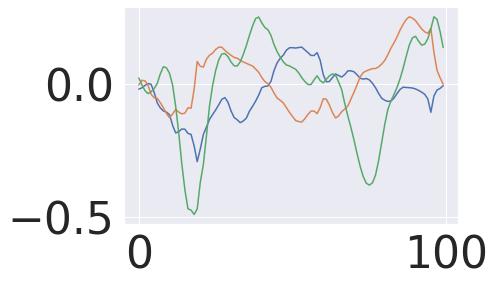

In [39]:
plt.plot(X_train.squeeze()[0, 0:3].T)

In [11]:
#Example predictions
pred = np.round(model.predict(X_val, batch_size = batch_size)).squeeze()#.squeeze().swapaxes(-1, -2))).squeeze()
print(f"{pred.sum()/len(pred)} of the predictions were 1 (Male)")

0.7589051416915902 of the predictions were 1 (Male)


In [12]:
np.sum(pred == y_val), pred.shape

(514010, (698136,))

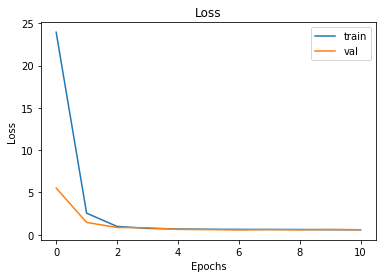

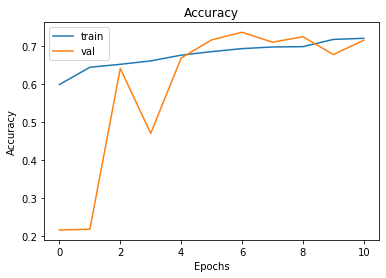

In [13]:
plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.show()

plt.figure()
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='val')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.show()

Text(0.5, 1, 'Gender Prediction Confusion Matrix')

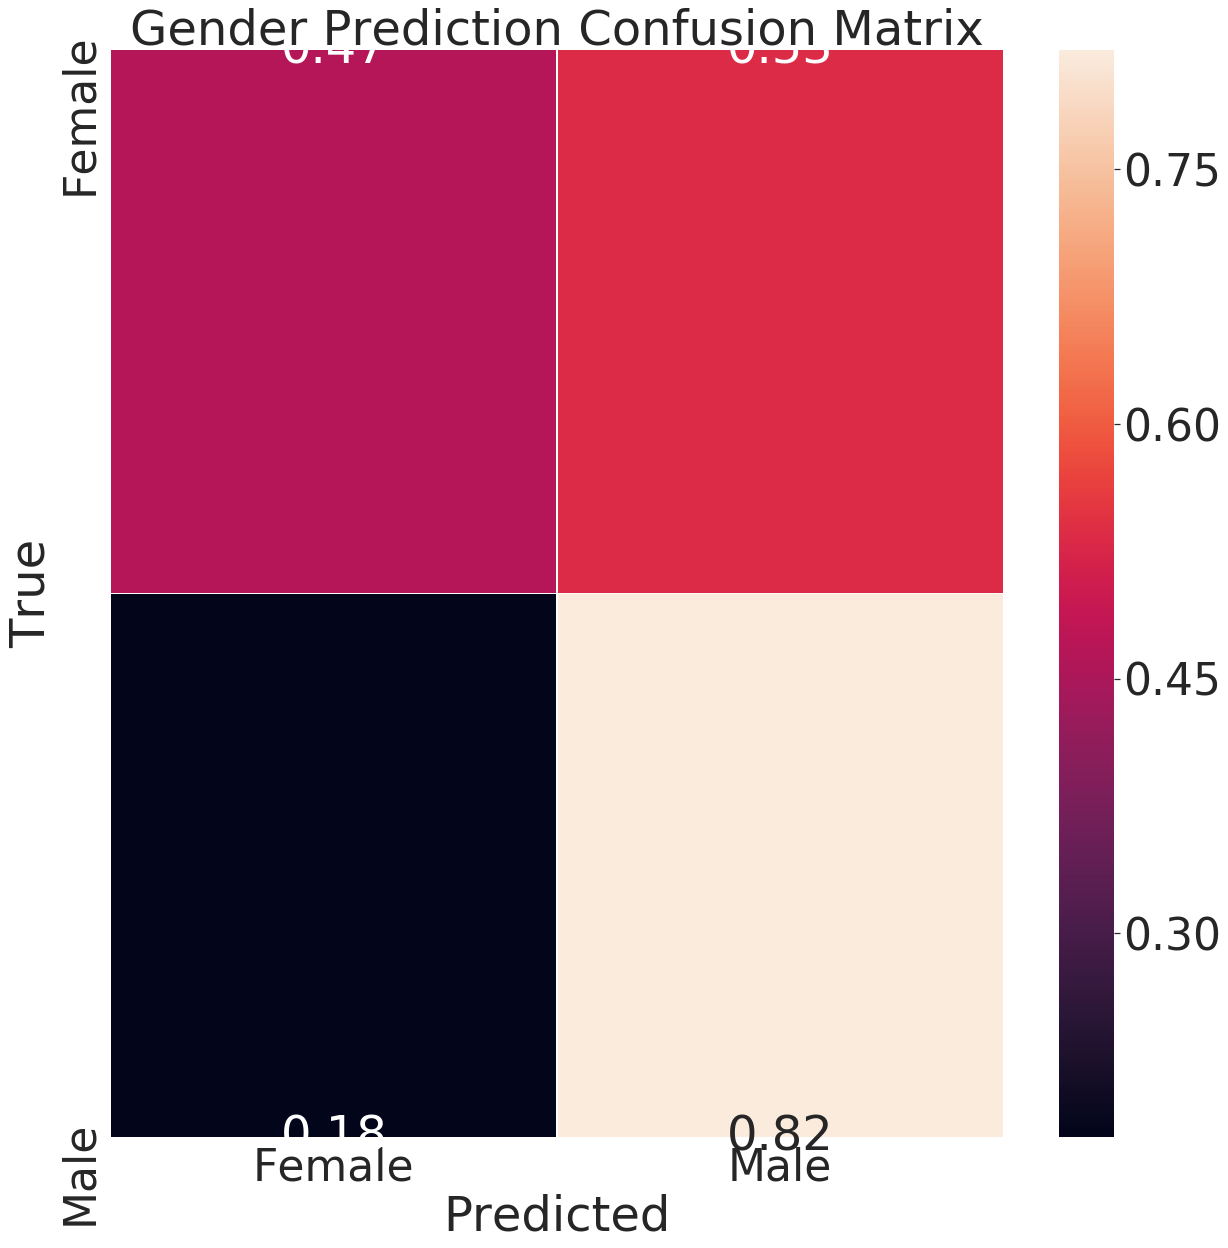

In [28]:
#Print confusion matrix
y_pred = model.predict(X_test, batch_size = batch_size)

import seaborn as sns
fig, ax = plt.subplots(figsize=(20,20)) 
df_results=pd.DataFrame(data=np.column_stack((y_test,y_pred.round())),columns=['True','Predicted'])
CT_results=pd.crosstab(df_results["True"], df_results["Predicted"]).apply(lambda r: r/r.sum(), axis=1)

#Make a heatmap
sns.set(font_scale = 4)
sns.heatmap(CT_results, 
            annot=True,
            xticklabels = ['Female', 'Male'],
            yticklabels = ['Female', 'Male'],
            fmt=".2f", 
            linewidths=.5,
            ax=ax)
plt.title('Gender Prediction Confusion Matrix')

AUROC: 0.7464437349692364


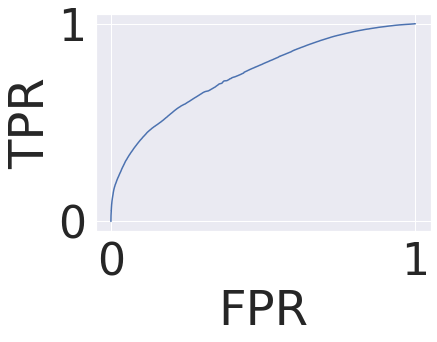

EER Threshold: 0.61762094 EER:  0.33047465695883504


Text(0.5, 1, 'Gender Prediction Confusion Matrix')

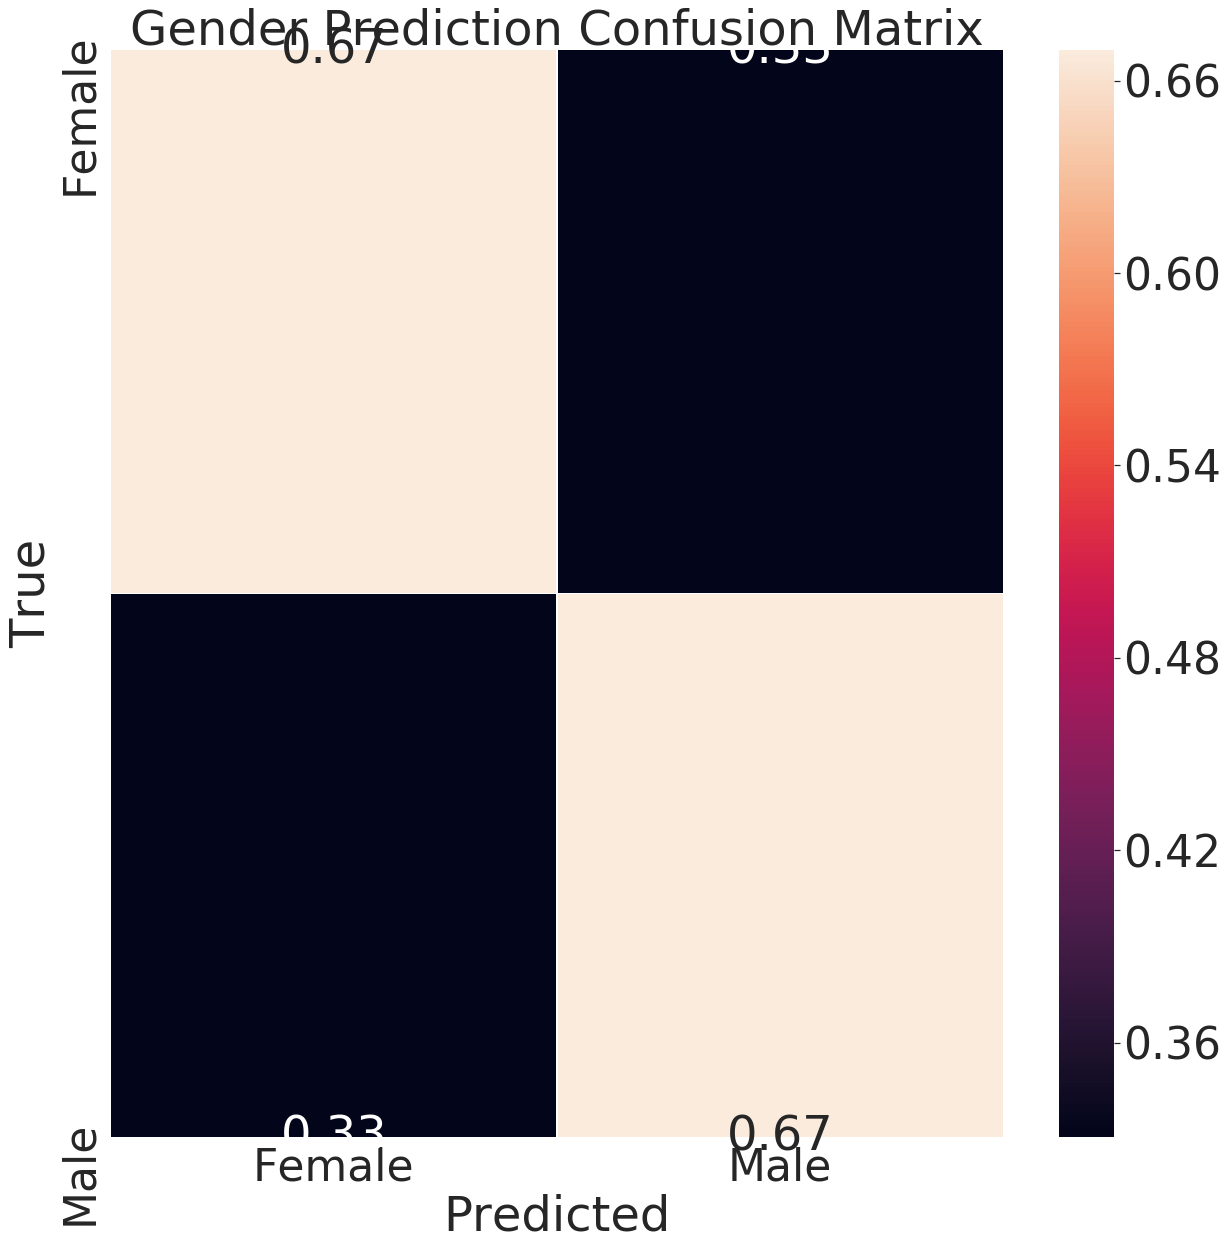

In [31]:
#ROC curve
from sklearn import metrics
y_score = model.predict(X_test, batch_size = batch_size)
fpr, tpr, threshs = metrics.roc_curve(y_test, y_score)

print("AUROC: {}".format(metrics.roc_auc_score(y_test, y_score)))

plt.figure()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

fnr = 1 - tpr
eer_threshold = threshs[np.nanargmin(np.absolute((fnr - fpr)))]
EER = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
print("EER Threshold:", eer_threshold, "EER: ", EER)

fig, ax = plt.subplots(figsize=(20,20)) 
df_results=pd.DataFrame(data=np.column_stack((y_test,y_score > eer_threshold)),columns=['True','Predicted'])
CT_results=pd.crosstab(df_results["True"], df_results["Predicted"]).apply(lambda r: r/r.sum(), axis=1)

#Make a heatmap
sns.set(font_scale = 4)
sns.heatmap(CT_results, 
            annot=True,
            xticklabels = ['Female', 'Male'],
            yticklabels = ['Female', 'Male'],
            fmt=".2f", 
            linewidths=.5,
            ax=ax)
plt.title('Gender Prediction Confusion Matrix')

AUROC: 0.9009191094591908


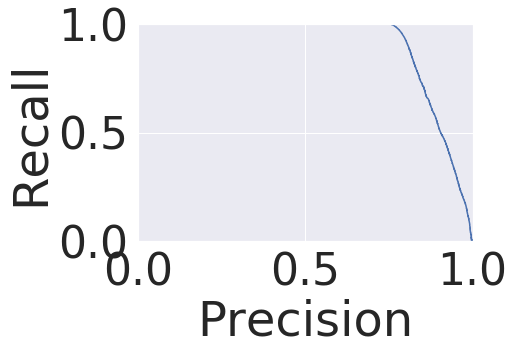

In [22]:
#PRC
p, r, threshs = metrics.precision_recall_curve(y_test, y_score)

print("AUROC: {}".format(metrics.average_precision_score(y_test, y_score)))

plt.figure()
plt.plot(p, r)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

# Get user-level predictions

In [36]:
y_round = y_pred > eer_threshold
thresh = 0.5
unique_ids = np.unique(ids_test)
print(f'There are {len(unique_ids)} unique ids in our test set.')

user_preds = []
user_trues = []

overall_acc = []
male_acc = []
female_acc = []
for usr_id in unique_ids:
    
    usr_idxs = np.nonzero(ids_test == usr_id)[0]
    
    #print(f'User {usr_id} has {len(usr_idxs)} in the val set.')

    temp = np.sum(y_round[usr_idxs])/len(usr_idxs)
    pred = temp > thresh
    true = y_test[usr_idxs[0]]
    #print(f'This user has label {true} with vote {temp} leading to a aggregate prediction of {pred}.')

    user_preds.append(pred)
    user_trues.append(true)
    
    overall_acc.append(true == pred)
    if true == 1:
        male_acc.append(true == pred)
    else:
        female_acc.append(true == pred)

There are 492 unique ids in our val set.


In [37]:
np.sum(overall_acc)/len(overall_acc)

0.7276422764227642

In [38]:
np.sum(female_acc)/len(female_acc)

0.7768595041322314

In [39]:
np.sum(male_acc)/len(male_acc)

0.7115902964959568

Text(0.5, 1, 'Gender Prediction Confusion Matrix')

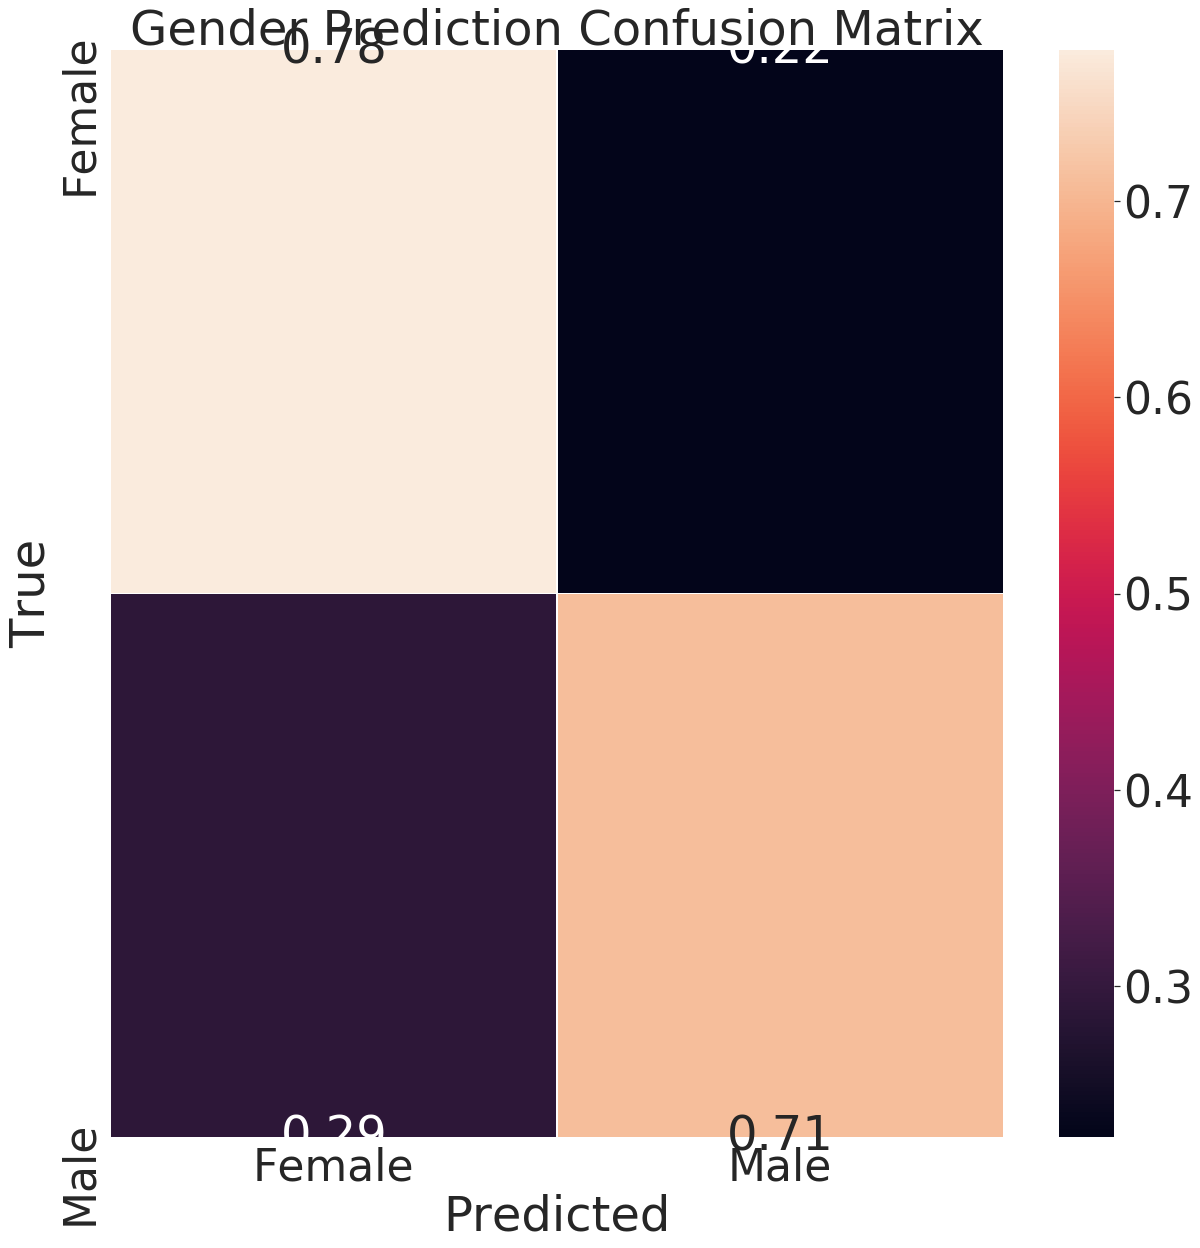

In [40]:
#Print confusion matrix
import seaborn as sns
fig, ax = plt.subplots(figsize=(20,20)) 
df_results=pd.DataFrame(data=np.column_stack((user_trues, user_preds)),columns=['True','Predicted'])
CT_results=pd.crosstab(df_results["True"], df_results["Predicted"]).apply(lambda r: r/r.sum(), axis=1)

#Make a heatmap
sns.set(font_scale = 4)
sns.heatmap(CT_results, 
            annot=True,
            xticklabels = ['Female', 'Male'],
            yticklabels = ['Female', 'Male'],
            fmt=".2f", 
            linewidths=.5,
            ax=ax)
plt.title('Gender Prediction Confusion Matrix')

# SHAP it

In [52]:
import shap
shap.initjs()

In [53]:
# select a set of background examples to take an expectation over
background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]

# explain predictions of the model on four images
e = shap.DeepExplainer(model, background)

[ 63532 520772 290681 688975 621576]


<Figure size 1800x720 with 0 Axes>

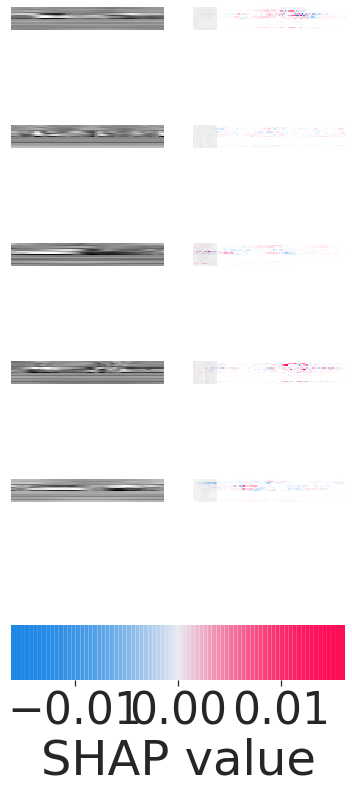

In [54]:
random_idxs = np.random.choice(np.arange(X_val.shape[0]), 5)
print(random_idxs)

shap_values = e.shap_values(X_val[random_idxs])

#Hack the dims a little
shap_values = [np.transpose(value, (0, 2, 3, 1)) for value in shap_values]
im_val = np.transpose(X_val, (0, 2, 3, 1))

# plot the feature attributions
plt.figure(figsize=(25, 10))
shap.image_plot(shap_values, -im_val[random_idxs], width = 100, aspect = 1)

Walk Cycle 0


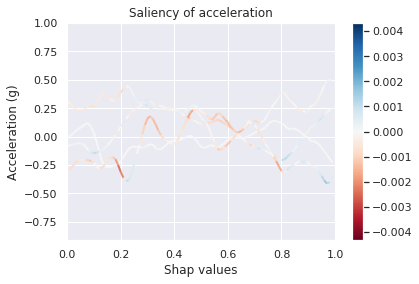

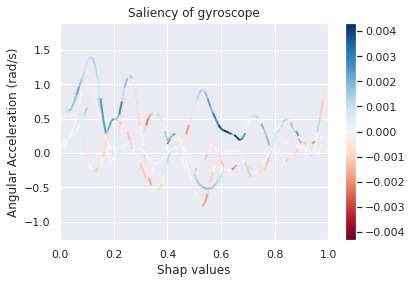

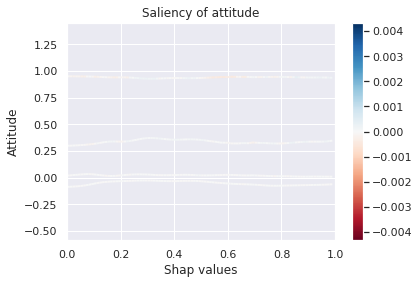

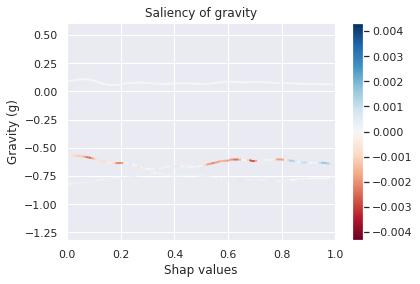

Walk Cycle 1


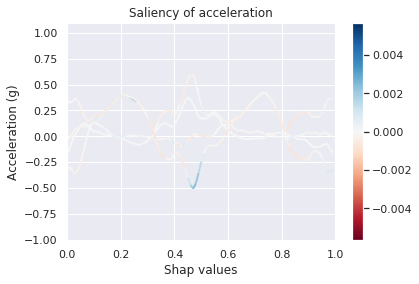

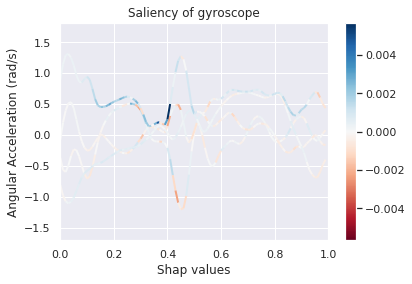

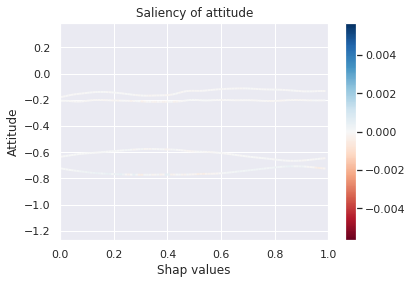

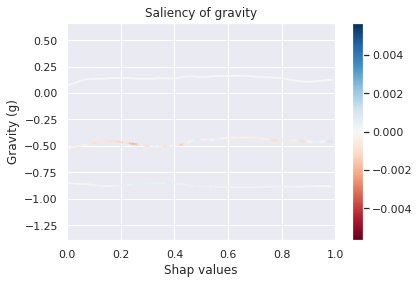

Walk Cycle 2


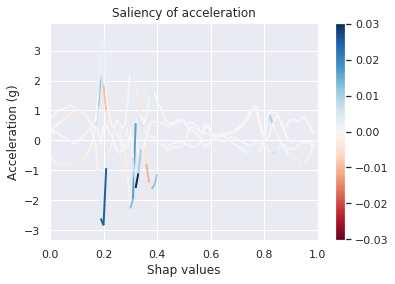

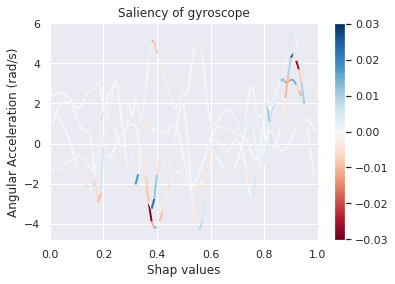

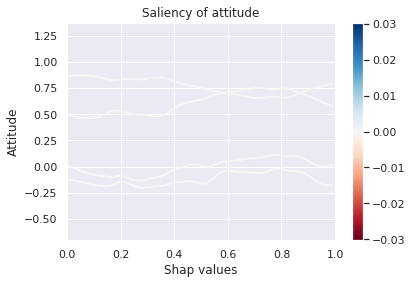

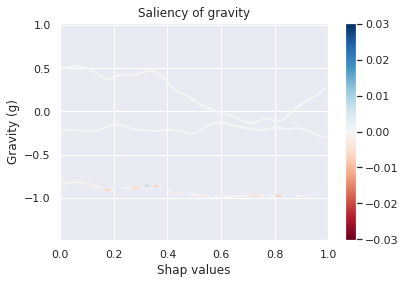

Walk Cycle 3


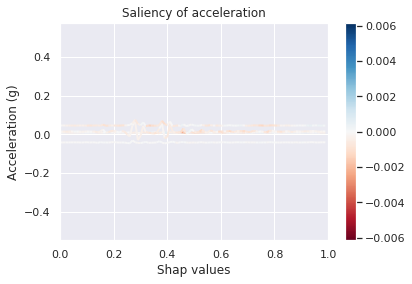

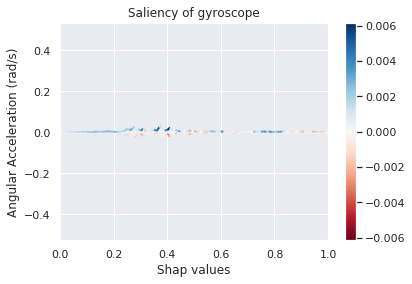

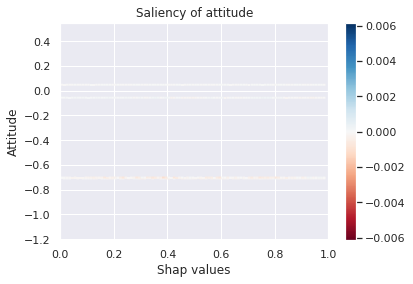

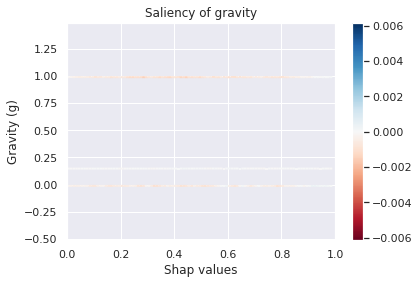

Walk Cycle 4


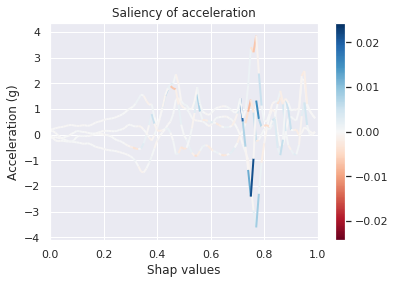

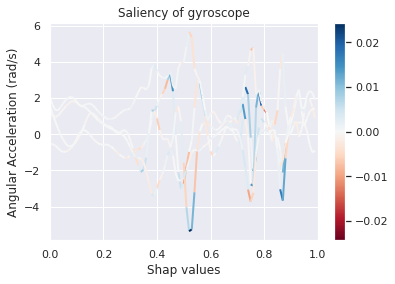

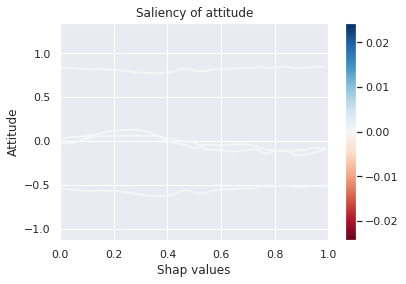

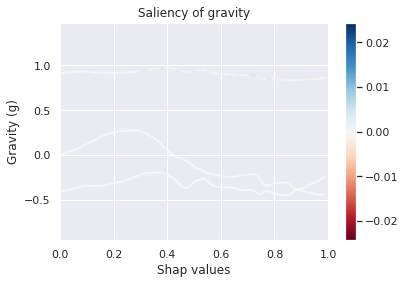

In [57]:
# Create a set of line segments so that we can color them individually
# This creates the points as a N x 1 x 2 array so that we can stack points
# together easily to get the segments. The segments array for line collection
# needs to be (numlines) x (points per line) x 2 (for x and y)

sns.set(font_scale = 1)

def plot_colored_data(data, color, shap_color_scale = None, fignum = 0, colorbar = False):
    from matplotlib.collections import LineCollection

    x = np.arange(0, len(data)) / 100
    points = np.array([x, data]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    fig = plt.figure(fignum)
    ax = plt.gca()

    # Create a continuous norm to map from data points to colors
    if shap_color_scale == None:
        norm = plt.Normalize(min(color), max(color))
    else:
        norm = plt.Normalize(-shap_color_scale, shap_color_scale)
    lc = LineCollection(segments, cmap='RdBu', norm=norm)

    # Set the values used for colormapping
    lc.set_array(color)
    lc.set_linewidth(2)
    line = ax.add_collection(lc)
    if colorbar:
        fig.colorbar(line, ax = ax)

    
def plot_window_saliency(image, shap, base_fignum = 0):
    wc_data = image.squeeze()
    wc_saliency = shap.squeeze()
    largest_shap = np.max(np.abs(wc_saliency))

    #Plotting Accel
    plt.figure(base_fignum)
    for i in range(4):
    
        plot_colored_data(wc_data[i], wc_saliency[i], largest_shap, fignum = base_fignum, colorbar = i == 3)
    
    plt.title('Saliency of acceleration')
    plt.ylabel('Acceleration (g)')
    plt.xlabel('Shap values')
    plt.xlim([0, 1])
    plt.ylim([np.min(wc_data[0:4]) - 0.5, np.max(wc_data[0:4]) + 0.5])
    
    #Plotting gyro
    plt.figure(base_fignum + 1)
    for i in range(4, 8):
    
        plot_colored_data(wc_data[i], wc_saliency[i], largest_shap, fignum =base_fignum +  1, colorbar = i == 7)
    
    plt.title('Saliency of gyroscope')
    plt.ylabel('Angular Acceleration (rad/s)')
    plt.xlabel('Shap values')
    plt.xlim([0, 1])
    plt.ylim([np.min(wc_data[4:8]) - 0.5, np.max(wc_data[4:8]) + 0.5])
    
    plt.figure(base_fignum + 2)
    for i in range(8,12):
    
        plot_colored_data(wc_data[i], wc_saliency[i], largest_shap, fignum =base_fignum +  2, colorbar = i == 11)
    
    plt.title('Saliency of attitude')
    plt.ylabel('Attitude')
    plt.xlabel('Shap values')
    plt.xlim([0, 1])
    plt.ylim([np.min(wc_data[8:12]) - 0.5, np.max(wc_data[8:12]) + 0.5])
    
    plt.figure(base_fignum + 3)
    for i in range(12, 15):
    
        plot_colored_data(wc_data[i], wc_saliency[i], largest_shap, fignum =base_fignum +  3, colorbar = i == 14)
    
    plt.title('Saliency of gravity')
    plt.ylabel('Gravity (g)')
    plt.xlabel('Shap values')
    plt.xlim([0, 1])
    plt.ylim([np.min(wc_data[12:15]) - 0.5, np.max(wc_data[12:15]) + 0.5])
    
def plot_cycle_saliency(model, X_train, X_val):
    import shap
    shap.initjs()
    
    # select a set of background examples to take an expectation over
    background = X_train[np.random.choice(X_train.shape[0], 200, replace=False)]

    # explain predictions of the model on four images
    e = shap.DeepExplainer(model, background)
    
    #Choose some random cycles to plot
    random_idxs = np.random.choice(np.arange(X_val.shape[0]), 5)
    val_cycles = X_val[random_idxs]

    shap_values = e.shap_values(val_cycles)[0]
    
    for idx in range(len(random_idxs)):
        print(f"Walk Cycle {idx}")
        plot_window_saliency(val_cycles[idx], shap_values[idx], 4*idx)
        plt.show()
        
plot_cycle_saliency(model, X_train, X_val)

# That's it folks!

Text(0.5, 1, 'Gender Prediction Confusion Matrix')

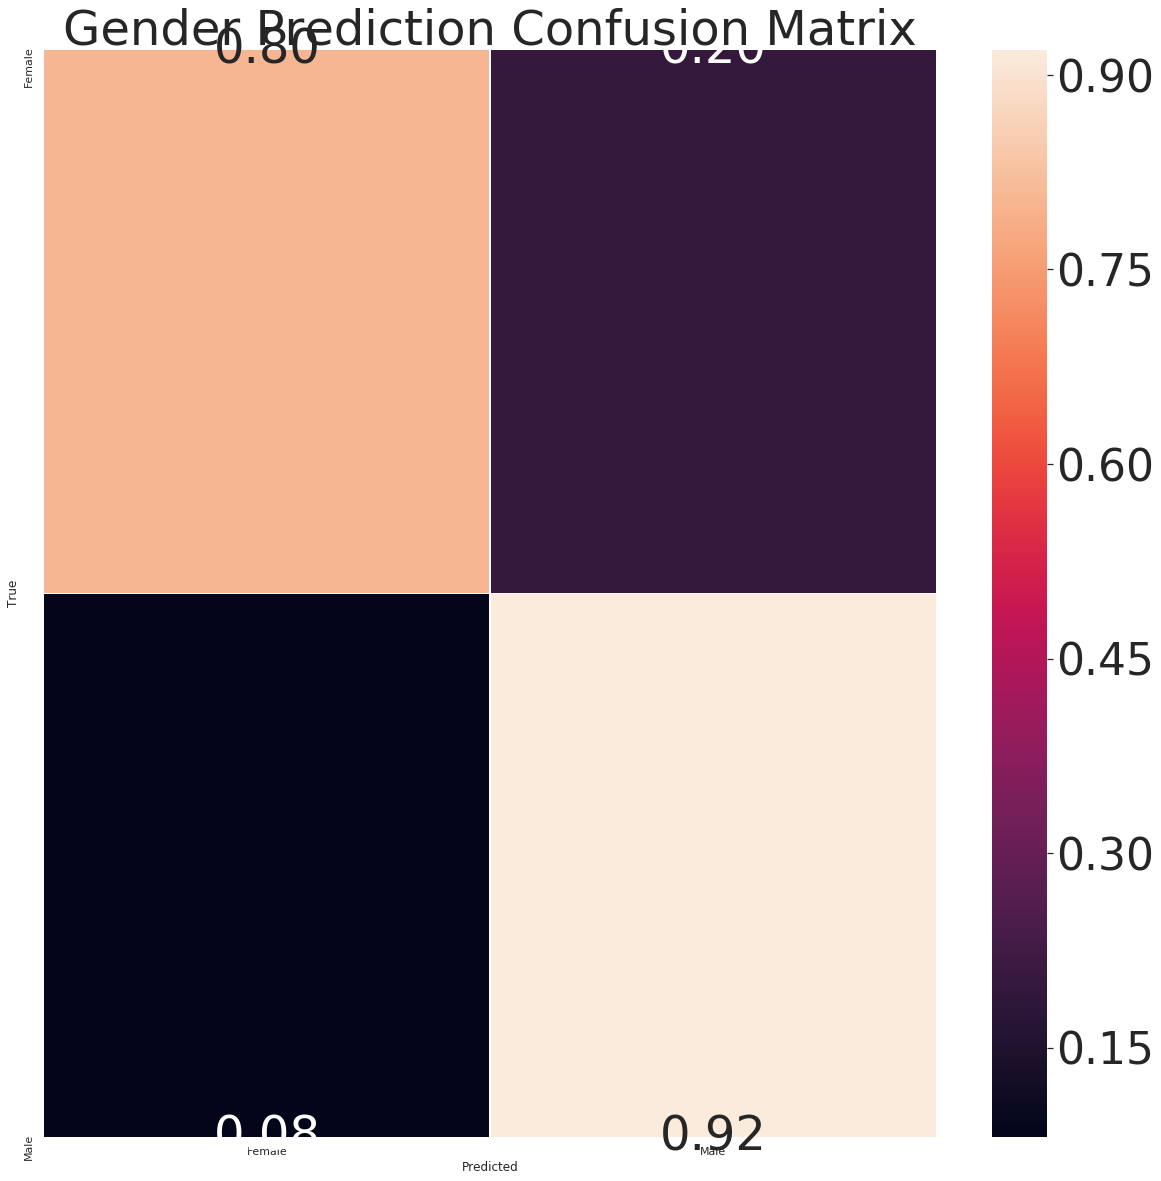

In [85]:
#Print confusion matrix
import seaborn as sns
y_pred = model.predict(X_val, batch_size = batch_size)
fig, ax = plt.subplots(figsize=(20,20)) 
df_results=pd.DataFrame(data=np.column_stack((y_val,y_pred.round())),columns=['True','Predicted'])
CT_results=pd.crosstab(df_results["True"], df_results["Predicted"]).apply(lambda r: r/r.sum(), axis=1)

#Make a heatmap
sns.set(font_scale = 4)
sns.heatmap(CT_results, 
            annot=True,
            xticklabels = ['Female', 'Male'],
            yticklabels = ['Female', 'Male'],
            fmt=".2f", 
            linewidths=.5,
            ax=ax)
plt.title('Gender Prediction Confusion Matrix')